In [54]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from collections import OrderedDict

In [55]:
data_path = Path('../data/Protera')

!ls $data_path

clustering   data.csv  mmseq_q	prefilter.out  search.out	stability.csv
cluster.out  mmseq     mmseq_t	prism	       sequences.fasta	tmp


In [56]:
data = pd.read_csv(data_path / "stability.csv")

## Data Duplication

In [57]:
len(data['sequences'].unique()) == len(data), data['sequences'].unique().shape, len(data)

(False, (142443,), 583851)

In [58]:
data = data.drop_duplicates()
data

,sequences,labels
0,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,0.226782
1,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,0.782184
2,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,1.151609
3,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,0.292759
4,QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAG...,-0.880000
...,...,...
202934,HKLRKLNPPDESGPGCMSCKCVLSSMTEYKLVVVGAGGVGKSALTI...,0.405517
202935,HKLRKLNPPDESGPGCMSCKCVLSTMTEYKLVVVGAGGVGKSALTI...,0.173793
202936,HKLRKLNPPDESGPGCMSCKCVLSVMTEYKLVVVGAGGVGKSALTI...,2.447356
202937,HKLRKLNPPDESGPGCMSCKCVLSWMTEYKLVVVGAGGVGKSALTI...,1.032299


## Alignments

In [65]:
%timeit pairwise2.align.localmx(data['sequences'][0], data['sequences'][1], 1, 0)

3.46 ms ± 732 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
%timeit pairwise2.align.globalxx(data['sequences'][0], data['sequences'][1])

694 µs ± 58.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [60]:
from Bio import pairwise2

alignment = pairwise2.align.globalxx(data['sequences'][0], data['sequences'][1])
print(pairwise2.format_alignment(*alignment[0]))

QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGA-Q
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||  |
QIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG-CQ
  Score=76



## Score per metrics

* More unique values => more stability?
* Does sequence length matter?


In [8]:
def append_to_key(d, k, v):
    if k in d:
        values = d[k]
        values.append(v)
        d[k] = values
        
    else:
        d[k] = [v]
        
def compute_mean_scores(d):
    new_d = dict()
    for k in d:
        mean_score = np.mean(d[k])
        new_d[k] = (mean_score, len(d[k]))
        
    return  OrderedDict(sorted(new_d.items()))

In [9]:
score_per_length = dict()
score_per_uniqueness = dict()

for idx, (seq, score) in data.iterrows():
    # score_per_length
    size = len(seq)
    append_to_key(score_per_length, size, score)
    
    
    # score_per_uniqueness => score per number of unique aminoacids in each seq
    uniques = set(seq)
    unique_size = len(uniques)
    
    append_to_key(score_per_uniqueness, unique_size, score)
    
    # count unique aminoacids
    for amino in uniques:
        uniques.add(amino)


In [10]:
compute_mean_scores(score_per_length)

OrderedDict([(67, (0.9057751840957926, 1102)),
             (74, (1.4451812751889404, 1349)),
             (77, (1.1445754647569504, 2812)),
             (103, (1.286925200436685, 3306)),
             (151, (1.1443029242667568, 2641)),
             (161, (1.634530384824353, 2983)),
             (166, (1.5775506460669793, 2964)),
             (179, (1.4971539885887808, 2907)),
             (191, (1.7890972966275298, 3154)),
             (233, (1.3742664851784707, 4332)),
             (245, (1.9083088648345037, 4256)),
             (247, (1.7661625151570426, 4351)),
             (252, (1.80805768275468, 4674)),
             (288, (1.9360205176701843, 4959)),
             (305, (0.9972862768821978, 1938)),
             (310, (1.4987711794857383, 2451)),
             (332, (2.2146651533399533, 6213)),
             (362, (1.7637988821771322, 6365)),
             (395, (1.6426984590222728, 3781)),
             (405, (1.758458296139091, 5833)),
             (415, (1.2377106719544715, 4104)),


In [11]:
compute_mean_scores(score_per_uniqueness)

OrderedDict([(17, (1.2191776852283291, 2368)),
             (18, (1.1524984137931022, 5000)),
             (19, (1.4371670347157923, 11246)),
             (20, (1.7104500806976233, 118927)),
             (21, (1.79797436654989, 4902))])

## By Score

In [12]:
sorted_train = data.sort_values(by='labels')
sorted_train = sorted_train.reset_index(drop = True)

In [68]:
sorted_train['sequences'][0]

'PDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSGYHVEQEKENKLLCEDLPGTEDFVGHQGTVPSDNIDSQGRNCSTNDSLLWMGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIETLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYANETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLQKIDKSEGRFHVQNLSQVEQDGRTGHGLRRSSKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSP'

In [67]:
sorted_train['sequences'][1]

'PAVALYTKLGIREEVMHFDIDPSTATWMLRSSNDVTQQGSRPKTKLGGSSMGIIRTCRLGPDQVKSMRAALDLFGREFGDVATYSQHQPDSDYLGNLLRSKTFIALAAFDQEAVVGALAAYVLPKFEQPRSEIYIYDLAVSGEHRRQGIATALINLLKHEANALGAYVIYVQADYGDDP'

In [13]:
alignment = pairwise2.align.globalxx(sorted_train['sequences'][0], sorted_train['sequences'][1])
print(pairwise2.format_alignment(*alignment[0]))

sorted_train.head(5)

PDFRIAFQELLCLRRSSLK-AYGNG-YSSNGNTGEQSGYHVEQEKENKLLCEDLPGT--EDF-VG-HQGTVPS-DNIDSQGRNC-STNDSLL--WMGQPGNGSAFLLAPNG-SHAPDH--DVTQE---RDEVWVV-----GMGIVMSLIVLAIVF--GNVLVITAIAKFERLQTVTNYFITSLACAD-LVMGLAVVPFG-------AAHILMKMWT--FGNFWC-EFWTSI-DVLCVTASIETLCVIAVDRYFAITSPFKYQ----SL--LTK-NKARVIILMVWIVSGLT-S--FLPIQMHWYRATHQE-AINCYANETCCDFFTN-QAYAI-ASSIVSFYVP--LVIMVFV--YSRVFQEAKRQLQKID-KSEGRFHV-QNL--SQVEQ----DGRTGHGLRRS--SKFCLK-EHKALKTL---GIIMGTF-TLCW-LPFFIVNIVHVIQDNLIR-K-EVYILL-NWI--G-YVNSGFNPLIYCRS--------P
|    |              |     |     |              |     | |   |   |  |       | ||       ||       ||          |     |       ||||    |           | |   |          |    |  |    |         |   |   |  |    |         ||  |       ||     ||     |   | |   |        |    |    |    |   |   |      |       |  |  |  |      |     |    |       |   |     |   |   |   |        |  |       |     |    |   |    |  |     |      |     |      ||         | |     |    |          |  ||   | |      |    | ||       ||           |
P---

,sequences,labels
0,PDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSGYHVEQEKENK...,-6.076782
1,PAVALYTKLGIREEVMHFDIDPSTATWMLRSSNDVTQQGSRPKTKL...,-5.827586
2,TELTTKGRVPYPGMVNREXLDQVERGYRMPCPPECPEXLHDLMCQC...,-5.286897
3,PLAHYDTTADEILQQCDGKLDMLVASVGTGGTITGIARKLKEKCPG...,-5.237471
4,PDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSGYHVEQEKENK...,-4.742644


In [14]:
alignment = pairwise2.align.globalxx(
    sorted_train['sequences'][len(sorted_train)-1], 
    sorted_train['sequences'][len(sorted_train)-2]
)

print(pairwise2.format_alignment(*alignment[0]), \
      sorted_train['sequences'][len(sorted_train)-1] == sorted_train['sequences'][len(sorted_train)-2])

sorted_train.tail(5)

GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGFLKEEDLTEKKPWWWHLRVQELGLSAPLTVLPTITCGHTIEILREKGFDQAPVVDEAGVILGMVTLGNMLSSLLAGKVQPSDQVGKVIYKQFKQIRLTDTLGRLSHILEMDHFALVVHEQIQYHSTGKSSQRQMVFGVVTAIDLLNFVAAQERDQKW-MPSETPQAEVGPTGCPHRSGPHSAKGSLEKGSPEDKEAKEPLWIRPDAPSRCTWQLGRPASESPHHHTAPAKSPKILPDILKKIGDTPMVRINKIGKKFGLKCELLAKCEFFNAGGSVKDRISLRMIEDAERDGTLKPGDTIIEPTSGNTGIGLALAAAVRGYRCIIVMPEKMSSEKVDVLRALGAEIVRTPTNARFDSPESHVGVAWRLKNEIPNSHILDQYRNASNPLAHYDTTADEILQQCDGKLDMLVASVGTGGTITGIARKLKEKCPGCRIIGVDPEGSILAEPEELNQTEQTTYEVEGIGYDFIPTVLDRTVVDKWFKSNDEEAFTFARMLIAQEGLLCGGSAG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||  ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

,sequences,labels
142438,GCRAIGLGGGASSRVLADGMTRGPVVRLPRACDSAEVKAWLETSEG...,45.396552
142439,GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGF...,46.291724
142440,GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGF...,52.328276
142441,GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGF...,54.201034
142442,GSTVAVAVKAAQELQEGQRCVVILPDSVRNYMTKFLSDRWMLQKGF...,82.530115


## Subsampling techniques

* Diversity Maximizing: This is a greedy strategy which starts from the reference and adds the sequence with highest average hamming distance to current set of sequences.

* Diversity Minimizing: This strategy is equivalent to the Diversity Maximizing strategy, but adds the se- quence with lowest average hamming distance. It is used to explore the effects of diversity on model per- formance.

* HHFilter: This strategy applies hhfilter (Steinegger etal.,2019)withthe-diff Mparameter,whichre- turns M or more sequences that maximize diversity (the result is usually close to M). If more than M sequences are returned we apply the Diversity Maxi- mizing strategy on top of the output.

In [15]:
import numpy as np

def onehot_pair(u, v):
    vocab = set(u).union(set(v))
    mapping = {k: v for v, k in enumerate(vocab)}
    
    for idx, val in enumerate(u):
        u[idx] = mapping[val]
    
    for idx, val in enumerate(v):
        v[idx] = mapping[val]
        
    return u, v

def onehot_arrays(arrays):
    vocab = set()
    for array in arrays[1:]:
        vocab = vocab.union(set([char for char in array]))
    
    mapping = {k: v for v, k in enumerate(vocab)}
    
    array_final = np.empty_like(arrays)
    for idx, string in enumerate(arrays):
        array = np.array([char for char in string])
        for arr_idx, val in enumerate(array):
            array[arr_idx] = mapping[val]
        array_final[idx] = array
        
    return array_final

def _validate_vector(u, dtype=None):
    u = np.asarray(u, dtype=dtype)
    if u.ndim == 1:
        return u

    # Ensure values such as u=1 and u=[1] still return 1-D arrays.
    u = np.atleast_1d(u.squeeze())
    if u.ndim > 1:
        raise ValueError("Input vector should be 1-D.")
    warnings.warn(
        "scipy.spatial.distance metrics ignoring length-1 dimensions is "
        "deprecated in SciPy 1.7 and will raise an error in SciPy 1.9.",
        DeprecationWarning)
    return u

def hamming(u, v):
    if np.array(u).dtype == "<U1" and np.array(v).dtype == "<U1":
        u, v = onehot_pair(u, v)
    u = _validate_vector(u)
    v = _validate_vector(v)
        
    u_ne_v = u != v
    
    return np.average(u_ne_v)

In [16]:
import random
from scipy.spatial.distance import hamming
from tqdm.autonotebook import tqdm

import multiprocessing
import contextlib

def compute_diversity(seq1, seq2, method="hamming"):
    if method == "alignment":
        method = pairwise2.align.globalxx
        diversity = method(seq1, seq2)
        diversity = diversity[0].score / max(len(seq1), len(seq2))

    elif method == "hamming":
        if len(seq1) != len(seq2):
            size = min(len(seq1), len(seq2))
            seq1 = seq1[:size]
            seq2 = seq2[:size]
            
        method = hamming
        #print(list(seq1), "\n" ,list(seq2))
        diversity = method(list(seq1), list(seq2))
    
    return diversity


def div_vs_all(sequence, other_sequences, reducer = np.nanmean):
        if seq in other_sequences:
            raise IndexError(
                f"{seq_idx} is in other_sequences, e.g. it is not correctly indexed"
            )
        v_diversity = np.vectorize(lambda x: compute_diversity(seq, x))
        if len(other_sequences) > 1:
            div_vs_all = v_diversity(other_sequences)
        else:
            print(f"Skipping sequence {seq_idx}")
            return np.nan

        reduced_div_vs_all = reducer(div_vs_all) if len(div_vs_all) >= 1 else np.nan
        return reduced_div_vs_all
    
def dataset_diversity(sequences, method="hamming", reduce="mean", verbose=True):
    if reduce != "mean":
        raise NotImplementedError
    else:
        # nan results are due to different lengths
        reducer = np.nanmean

    reduced_divs = []
    if verbose:
        pbar = tqdm(total=len(sequences), miniters=1, smoothing=1)

    all_other_sequences = [
        np.concatenate((sequences[:idx], sequences[idx + 1 :]))
        for idx in range(len(sequences))
    ]
    
    
    with contextlib.closing(multiprocessing.Pool(8)) as pool:
        for seq_idx, seq in enumerate(sequences):
            other_sequences = all_other_sequences[seq_idx]
            reduced_divs.append(pool.apply_async(div_vs_all, args=(seq, other_sequences)))
            
            
    for idx, result in enumerate(reduced_divs):
        reduced_divs[idx] = result.get()
        if verbose:
            pbar.update(1)
            pbar.refresh()
        
    pool.join()

    if verbose:
        pbar.close()

    return reduced_divs

/tmp/ipykernel_31220/753373872.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [17]:
compute_diversity(
    data["sequences"].values[0],
    data["sequences"].values[11],
    "alignment",
)

0.987012987012987

In [18]:
compute_diversity(
    data["sequences"].values[0],
    data["sequences"].values[11],
    "hamming"
)

0.012987012987012988

In [19]:
len(data["sequences"].values) * 0.1

14244.300000000001

In [20]:
data["sequences"].values[::10].shape

(14245,)

In [21]:
#diversities = dataset_diversity(np.random.choice(data["sequences"].values, 14245))

In [52]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

records = []
for row_idx, row in tqdm(data.iterrows(), total=len(data)):
    record = SeqRecord(
        Seq(row.sequences),
        id=str(row[0]),
        name=f"mutagenesis_{row_idx}",
        description="",
        annotations={"labels": row.labels}
    )
    records.append(record)
    if len(row.sequences) > 6000: print(row_idx)
    
# SeqIO.write(records, data_path / "sequences.fasta", "fasta")

  0%|          | 0/142443 [00:00<?, ?it/s]

In [34]:
rep_records = []
for record in tqdm(SeqIO.parse(data_path / "clustering" / "clusterRes_rep_seq.fasta", "fasta")):
    rep_records.append(str(record.seq))
    
#rep_diversities = dataset_diversity(rep_records, "alignment")

0it [00:00, ?it/s]

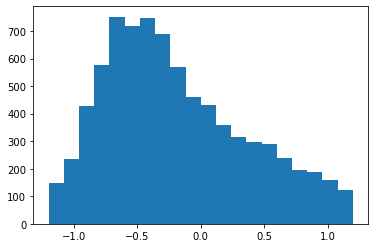

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y = scaler.fit_transform(data[data["sequences"].isin(rep_records)]["labels"].values.reshape(-1, 1))

plt.hist(y, bins=20, range=(-1.2,1.2))
plt.show()

In [ ]:
# ds_div_train = dataset_diversity(sets["train"]["sequence"])
# sets["train"]["diversity"] = np.nanmean(np.array(ds_div_train), 1)
# np.nanmean(np.array(ds_div_train))
# 0.8xxx

In [ ]:
# ds_div_test = dataset_diversity(sets["test"]["sequence"])
# sets["test"]["diversity"] = np.nanmean(np.array(ds_div_test), 1)
# np.nanmean(np.array(ds_div_test))

In [ ]:
# sets["train"].to_csv(f"{data_path}/stability_diversity_train.csv")
# sets["test"].to_csv(f"{data_path}/stability_diversity_test.csv")